## In this Series, I want to show the source code for a fully pipeline to train and make predictions. The implementation is subject to comments from Hau Nguyen, which you can see [here](https://www.kaggle.com/competitions/learning-equality-curriculum-recommendations/discussion/381509).

## The complete architecture for this process is described as follows

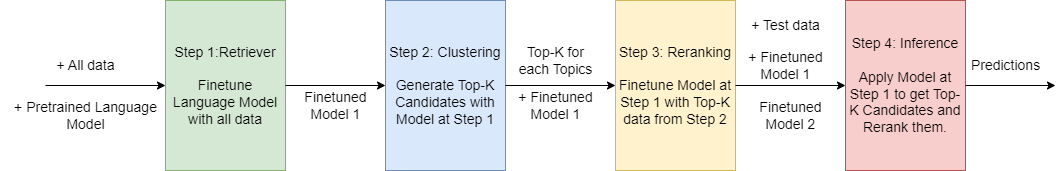

Reference: As a basis for my work, let me use the following these source code:

* Step 1: https://www.kaggle.com/code/andtaichi/finetunig-sentencetransformer by Taichi

* Step 2: https://www.kaggle.com/code/ragnar123/lecr-unsupervised-train-set-public by Martin 

* Step 3: https://www.kaggle.com/code/ragnar123/lecr-xlm-roberta-base-baseline by Martin

* Step 4: https://www.kaggle.com/code/ragnar123/lecr-inference-p by Martin

<b> Please upvote if you like these above notebooks, they really helped me a lot. Thank you so much! </b>







In [1]:
!pip -qqq install sentence-transformers

In [2]:
import wandb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim.swa_utils as swa
import tokenizers, transformers
import os, sys, gc, time, random, warnings, math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matp
import matplotlib.gridspec as gridspec

from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.checkpoint import checkpoint

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup, DataCollatorWithPadding
from sklearn.model_selection import StratifiedGroupKFold, KFold
from tqdm.auto import tqdm
from glob import glob
from sentence_transformers import SentenceTransformer, models, InputExample, losses
from datasets import Dataset
from kaggle_secrets import UserSecretsClient
warnings.filterwarnings("ignore")
%env TOKENIZERS_PARALLELISM=false
%matplotlib inline

env: TOKENIZERS_PARALLELISM=false


In [3]:
# WandB Login => Copy API Key
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

!wandb login $secret_value_0

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
# Breadcrumbs 
class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids.split()]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs(self, separator=" ", include_self=False, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join(reversed([a.title for a in ancestors]))

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        markdown = "  " * depth + "- " + self.title + "\n"
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
        for content in self.content:
            markdown += ("  " * (depth + 1) + "- " + "[" + content.kind.title() + "] " + content.title) + "\n"
        return markdown

    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"


class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics(self):
        return [Topic(topic_id) for topic_id in topics_df.loc[correlations_df[correlations_df.content_ids.str.contains(self.id)].index].index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

    def __eq__(self, other):
        if not isinstance(other, ContentItem):
            return False
        return self.id == other.id

    def get_all_breadcrumbs(self, separator=" >> ", include_root=True):
        breadcrumbs = []
        for topic in self.topics:
            new_breadcrumb = topic.get_breadcrumbs(separator=separator, include_root=include_root)
            if new_breadcrumb:
                new_breadcrumb = new_breadcrumb + separator + self.title
            else:
                new_breadcrumb = self.title
            breadcrumbs.append(new_breadcrumb)
        return breadcrumbs

In [5]:
# topics_df => topics, content_df => content, correlations_df => correlations
data_path = "/kaggle/input/learning-equality-curriculum-recommendations/"
topics_df = pd.read_csv(data_path + "topics.csv")
content_df = pd.read_csv(data_path + "content.csv")
correlations_df = pd.read_csv(data_path + "correlations.csv")

In [6]:
topic_ids = topics_df.id.to_list()
topics_df.set_index(keys='id', inplace=True)
topics_df.insert(0, 'id', topic_ids)

In [7]:
"""
[topic dataset]
1) change data shape
    - title + special token + description + special token + context
2) remove category == source data
"""
# Remove category == source topics_df => Mention in Host's Tips 
topics_df = topics_df[topics_df['category'] != 'source']

# title NaN
topics_df['title'].fillna("", inplace = True)
content_df['title'].fillna("", inplace = True)

# descriptions NaN
topics_df['description'].fillna("", inplace = True)
content_df['description'].fillna("", inplace = True)

# text NaN
content_df['text'].fillna("", inplace=True)

# topic-description
for i in tqdm(range(len(topics_df))):
    context = Topic(topics_df.iloc[i, 0]).get_breadcrumbs()
    topic_feature = topics_df.iloc[i, 2] # select description feature
    if len(topic_feature) != 0:
        try:
            idx = topic_feature.index('.')
            first_sentence = topic_feature[0:idx] # first sentence in Full sentence
            if len(first_sentence.split(' ')) <= 40:
                topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + first_sentence + ' <|=t_sep=|> ' + context
            else:
                first_sentence = first_sentence.split(' ')[0:40]
                first_sentence = ' '.join(first_sentnce)
                topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + first_sentence + ' <|=t_sep=|> ' + context

        except:
            if len(topic_feature.split(' ')) <= 40:
                topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + topic_feature + ' <|=t_sep=|> ' + context
            else:
                topic_feature = topic_feature.split(' ')[0:40]
                topic_feature = ' '.join(topic_feature)
                topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + topic_feature + ' <|=t_sep=|> ' + context

    else: # case: NaN
        topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + context

# content_df-description or text
for i in tqdm(range(len(content_df))):
    if len(content_df.iloc[i,2]) != 0: # 둘다 있는 애들, description만 있는 애들 걸리고
        content_df_feature = content_df.iloc[i,2]
        try:
            idx = content_df_feature.index('.')
            first_sentence = content_df_feature[0:idx]
            if len(first_sentence.split(' ')) <= 40:
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + first_sentence
            else:
                first_sentence = first_sentence.split(' ')[0:40]
                first_sentence = ' '.join(first_sentence)
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + first_sentence
            continue
        except:
            if len(content_df_feature.split(' ')) <= 40:
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + content_df_feature
            else:
                content_df_feature = content_df_feature.split(' ')[0:40]
                content_df_feature = ' '.join(content_df_feature)
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + content_df_feature
            continue

    if len(content_df.iloc[i,2]) == 0 and len(content_df.iloc[i,4]) != 0:
        content_df_feature = content_df.iloc[i,4]
        try:
            idx = content_df_feature.index('.')
            first_sentence = content_df_feature[0:idx]
            if len(first_sentence.split(' ')) <= 40:
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + first_sentence
            else:
                first_sentence = first_sentence.split(' ')[0:40]
                first_sentence = ' '.join(first_sentence)
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + first_sentence
            continue
        except:
            if len(content_df_feature.split(' ')) <= 40:
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + content_df_feature
            else:
                content_df_feature = content_df_feature.split(' ')[0:40]
                content_df_feature = ' '.join(content_df_feature)
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + content_df_feature
            continue

    else:
        continue

  0%|          | 0/33485 [00:00<?, ?it/s]

  0%|          | 0/154047 [00:00<?, ?it/s]

In [8]:
# # topic token length
# len_topic = []
# for i in range(len(topics_df)):
#     len_topic.append(len(topics_df.iloc[i,1].split(' ')))
# print('------------- Length Statistic Info -------------')
# print('Max Length of Sentence : {}'.format(np.max(len_topic)))
# print('Min Length of Sentence : {}'.format(np.min(len_topic)))
# print('Mean Length of Sentence : {:.2f}'.format(np.mean(len_topic)))
# print('Std Length of Sentence : {:.2f}'.format(np.std(len_topic)))
# print('Median Length of Sentence : {}'.format(np.median(len_topic)))
# print('Q1 Length of Sentence : {}'.format(np.percentile(len_topic, 25)))
# print('Q3 Length of Sentence : {}'.format(np.percentile(len_topic, 75)))

In [9]:
# sns.set_style(style='dark')
# plt.figure(figsize=(20,15))
# plt.hist(len_topic)

In [10]:
# # content token length
# len_content = []
# for i in range(len(content_df)):
#     len_content.append(len(content_df.iloc[i,1].split(' ')))
# print('------------- Length Statistic Info -------------')
# print('Max Length of Sentence : {}'.format(np.max(len_content)))
# print('Min Length of Sentence : {}'.format(np.min(len_content)))
# print('Mean Length of Sentence : {:.2f}'.format(np.mean(len_content)))
# print('Std Length of Sentence : {:.2f}'.format(np.std(len_content)))
# print('Median Length of Sentence : {}'.format(np.median(len_content)))
# print('Q1 Length of Sentence : {}'.format(np.percentile(len_content, 25)))
# print('Q3 Length of Sentence : {}'.format(np.percentile(len_content, 75)))

In [11]:
# sns.set_style(style='dark')
# plt.figure(figsize=(20,15))
# plt.hist(len_content)

In [12]:
topics_list = topics_df.title.to_list()
content_list = content_df.title.to_list()
# need to loop: each model's vocab are different 
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [13]:
# # Check Real token length
# tokens_len, topic_token = [], [] 
# for topic in topics_list:
#     inputs = tokenizer.encode_plus(
#         topic,
#         return_tensors = None,
#         add_special_tokens = False,
#         truncation = True,
#         max_length = 192,
#         return_token_type_ids = True,
#         return_attention_mask = True    
#     )
#     topic_token.append(tokenizer.decode(inputs.input_ids))
#     tokens_len.append(len(inputs.input_ids))
# print('------------- Length Statistic Info -------------')
# print('Max Length of Sentence : {}'.format(np.max(tokens_len)))
# print('Min Length of Sentence : {}'.format(np.min(tokens_len)))
# print('Mean Length of Sentence : {:.2f}'.format(np.mean(tokens_len)))
# print('Std Length of Sentence : {:.2f}'.format(np.std(tokens_len)))
# print('Median Length of Sentence : {}'.format(np.median(tokens_len)))
# print('Q1 Length of Sentence : {}'.format(np.percentile(tokens_len, 25)))
# print('Q3 Length of Sentence : {}'.format(np.percentile(tokens_len, 75)))

In [14]:
# # Check Real token length
# tokens_len, content_token = [], []
# for content in content_list:
#     inputs = tokenizer.encode_plus(
#         content,
#         return_tensors = None,
#         add_special_tokens = False,
#         truncation = True,
#         max_length = 64,
#         return_token_type_ids = True,
#         return_attention_mask = True    
#     )
#     content_token.append(tokenizer.decode(inputs.input_ids))
#     tokens_len.append(len(inputs.input_ids))
# print('------------- Length Statistic Info -------------')
# print('Max Length of Sentence : {}'.format(np.max(tokens_len)))
# print('Min Length of Sentence : {}'.format(np.min(tokens_len)))
# print('Mean Length of Sentence : {:.2f}'.format(np.mean(tokens_len)))
# print('Std Length of Sentence : {:.2f}'.format(np.std(tokens_len)))
# print('Median Length of Sentence : {}'.format(np.median(tokens_len)))
# print('Q1 Length of Sentence : {}'.format(np.percentile(tokens_len, 25)))
# print('Q3 Length of Sentence : {}'.format(np.percentile(tokens_len, 75)))

In [15]:
# # renewal topic, content dataframe
# topics, content, correlations = topics_df, content_df, correlations_df
# topics.title, content.title = topic_token, content_token
# topics.reset_index(drop=True, inplace=True), content.reset_index(drop=True, inplace=True)

In [16]:
def cv_split(train, n_folds, seed):
    kfold = KFold(n_splits = n_folds, shuffle = True, random_state = seed)
    for num, (train_index, val_index) in enumerate(kfold.split(train)):
        train.loc[val_index, 'fold'] = int(num)
    train['fold'] = train['fold'].astype(int)
    return train

In [17]:
# kfolds = cv_split(correlations, 5, 42)
# correlations = kfolds[kfolds.fold != 0]
# correlations

In [18]:
# topics, content

In [19]:
# topics.rename(columns=lambda x: "topic_" + x, inplace=True)
# content.rename(columns=lambda x: "content_" + x, inplace=True)

In [20]:
# correlations["content_id"] = correlations["content_ids"].str.split(" ")
# corr = correlations.explode("content_id").drop(columns=["content_ids"])
# corr

In [21]:
# corr = corr.merge(topics, how="left", on="topic_id")
# corr = corr.merge(content, how="left", on="content_id")
# corr.dropna(subset=['topic_title'], how='any', axis=0, inplace=True)
# corr.reset_index(drop=True, inplace=True)

In [22]:
# corr["set"] = corr[["topic_title", "content_title"]].values.tolist()
# train_df = pd.DataFrame(corr["set"])

In [23]:
# train_df.set[1], train_df

In [24]:
# dataset = Dataset.from_pandas(train_df)
# dataset

In [25]:
# train_examples = []
# train_data = dataset["set"]
# n_examples = dataset.num_rows

# for i in range(n_examples):
#     example = train_data[i]
#     if example[0] == None: #remove None
#         print(example)
#         continue        
#     train_examples.append(InputExample(texts=[str(example[0]), str(example[1])]))

In [26]:
retriever_list = ["paraphrase-multilingual-mpnet-base-v2",]
#                   "all-MiniLM-L6-v2",]
#                   "all-MiniLM-L12-v2"]
        
for retriever in tqdm(retriever_list):
    # tokenizer
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/' + retriever)
    
    # tokenizing topic
    tokens_len, topic_token = [], [] 
    for topic in topics_list:
        inputs = tokenizer.encode_plus(
            topic,
            return_tensors = None,
            add_special_tokens = False,
            truncation = True,
            max_length = 192,
            return_token_type_ids = True,
            return_attention_mask = True    
        )
        topic_token.append(tokenizer.decode(inputs.input_ids))
        tokens_len.append(len(inputs.input_ids))
    
    # tokenizing content
    tokens_len, content_token = [], []
    for content in content_list:
        inputs = tokenizer.encode_plus(
            content,
            return_tensors = None,
            add_special_tokens = False,
            truncation = True,
            max_length = 64,
            return_token_type_ids = True,
            return_attention_mask = True    
        )
        content_token.append(tokenizer.decode(inputs.input_ids))
        tokens_len.append(len(inputs.input_ids))
    
    # renewal topic, content dataframe
    topics, content, correlations = topics_df, content_df, correlations_df
    topics.title, content.title = topic_token, content_token
    topics.reset_index(drop=True, inplace=True), content.reset_index(drop=True, inplace=True)
    
    # cross validation 
    kfolds = cv_split(correlations, 5, 42)
    kfolds.to_csv(f'{retriever}_kfold_0.csv', index=False)
    correlations = kfolds[kfolds.fold != 0]
    
    # dataframe preprocessing
    topics.rename(columns=lambda x: "topic_" + x, inplace=True)
    content.rename(columns=lambda x: "content_" + x, inplace=True)
    correlations["content_id"] = correlations["content_ids"].str.split(" ")
    corr = correlations.explode("content_id").drop(columns=["content_ids"])
    corr = corr.merge(topics, how="left", on="topic_id")
    corr = corr.merge(content, how="left", on="content_id")
    corr.dropna(subset=['topic_title'], how='any', axis=0, inplace=True)
    corr.reset_index(drop=True, inplace=True)
    corr["set"] = corr[["topic_title", "content_title"]].values.tolist()
    train_df = pd.DataFrame(corr["set"])
    dataset = Dataset.from_pandas(train_df)

    train_examples = []
    train_data = dataset["set"]
    n_examples = dataset.num_rows

    for i in range(n_examples):
        example = train_data[i]
        if example[0] == None: #remove None
            print(example)
            continue        
        train_examples.append(InputExample(texts=[str(example[0]), str(example[1])]))

    # Fine-Tune Stage
    model = SentenceTransformer('sentence-transformers/' + retriever)
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64)
    train_loss = losses.MultipleNegativesRankingLoss(model=model)
    num_epochs = 20
    warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data
    model.fit(train_objectives=[(train_dataloader, train_loss)],
              epochs=num_epochs,
              save_best_model = True,
              output_path= f'./{retriever}-exp_fold0_epochs10',
              warmup_steps=warmup_steps,
              use_amp=True)
    torch.cuda.empty_cache()
    del topics, content, correlations, dataset, kfolds, train_df, corr, model, train_dataloader, train_loss
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

<a href = 'paraphrase-multilingual-mpnet-base-v2-exp'>Download</a>